#Import Libraries and mount the drive to access the drive

In [1]:
%matplotlib inline
import numpy as np 
import pandas as pd
import glob
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import re
import os
import tensorflow as tf
import pickle

from sklearn import svm,metrics
from sklearn.preprocessing import StandardScaler,LabelBinarizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score,f1_score,classification_report,confusion_matrix 
from sklearn.model_selection import train_test_split
from scipy import stats
from scipy.signal import find_peaks
import os

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, Dense, Conv1D, MaxPooling1D, AveragePooling1D, Flatten, Dropout, ZeroPadding1D, UpSampling1D, LSTM, Reshape, Bidirectional
from keras.layers import Bidirectional, BatchNormalization, TimeDistributed, Activation
from tensorflow.keras.optimizers import SGD, Adam, RMSprop
from tensorflow.keras.utils import to_categorical

In [2]:
from google.colab import drive
drive.mount('/content/drive/')


Mounted at /content/drive/


In [3]:
import pandas as pd
%cd /content/drive/MyDrive/ECE542_sp2022_Project_TerrainRecognition

with open('ReadMe.txt', 'r') as f:
  text = f.read()
print(text)

/content/drive/.shortcut-targets-by-id/15qAg_VhIEGRIBGc6Uwr-dQssTLlpRNoO/ECE542_sp2022_Project_TerrainRecognition
Here is a brief description of the data:

  - "_x" files contain the xyz accelerometers and xyz gyroscope measurements from the lower limb.
  - "_x_time" files contain the time stamps for the accelerometer and gyroscope measurements. The units are in seconds and the sampling rate is 40 Hz.
  - "_y" files contain the labels. (0) indicates standing or walking in solid ground, (1) indicates going down the stairs, (2) indicates going up the stairs, and (3) indicates walking on grass.
  - "_y_time" files contain the time stamps for the labels. The units are in seconds and the sampling rates is 10 Hz.


The data set is imbalanced. Here are some suggestions for handling imbalance:

  1. Make sure you create a validation set that is also balanced in order to better represent the type of testing data you will get.
  2. You can modify your loss function to include weights that compen

In [ ]:
data_x_time=pd.read_csv("subject_008_01__x_time.csv",header=None)
data_x_time = data_x_time.rename(columns={data_x_time.columns[0]: 'time'})
data_x_time.head

<bound method NDFrame.head of            time
0         0.000
1         0.025
2         0.050
3         0.075
4         0.100
...         ...
48133  1203.325
48134  1203.350
48135  1203.375
48136  1203.400
48137  1203.425

[48138 rows x 1 columns]>

In [ ]:
data_x=pd.read_csv("subject_008_01__x.csv",header=None)
print(data_x.head)

<bound method NDFrame.head of               0         1         2         3         4         5
0      1.306857  9.407257 -2.487257 -0.004376 -0.000034  0.001111
1      1.343451  9.393098 -2.520354 -0.000866 -0.001356  0.000000
2      1.322976  9.380536 -2.521071  0.000783  0.001976  0.001275
3      1.330000  9.386873 -2.500309 -0.003865 -0.001786  0.002706
4      1.346465  9.390606 -2.522929 -0.000782 -0.000864  0.003169
...         ...       ...       ...       ...       ...       ...
48133  2.072244  8.908878 -3.500000  0.001351  0.001191  0.001031
48134  2.085123  8.915123 -3.520000  0.001918 -0.001147  0.000000
48135  2.083774  8.910000 -3.538981 -0.002015 -0.004099  0.001042
48136  2.111447  8.908553 -3.535724  0.000183 -0.001673  0.001856
48137  2.087730  8.900000 -3.518865  0.000052 -0.001267  0.000000

[48138 rows x 6 columns]>


In [ ]:
data_y_time=pd.read_csv("subject_008_01__y_time.csv",header=None)
data_y_time = data_y_time.rename(columns={data_y_time.columns[0]: 'time'})
data_y_time

time
0         0.02
1         0.12
2         0.22
3         0.32
4         0.42
...        ...
12030  1203.02
12031  1203.12
12032  1203.22
12033  1203.32
12034  1203.42

[12035 rows x 1 columns]

In [ ]:
data_y=pd.read_csv("subject_008_01__y.csv",header=None)
data_y = data_y.rename(columns={data_y.columns[0]: 'Output'})
data_y

Output
0           0
1           0
2           0
3           0
4           0
...       ...
12030       0
12031       0
12032       0
12033       0
12034       0

[12035 rows x 1 columns]

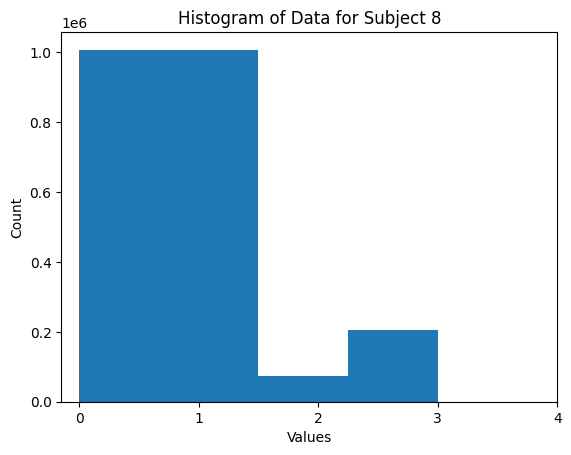

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots()
n, bins, patches = ax.hist(y_smote, bins=4)

# set the x-axis tick labels to integers
ax.set_xticks(range(len(bins)))

ax.set_title("Histogram of Data for Subject 8")
ax.set_xlabel("Values")
ax.set_ylabel("Count")
plt.show()


In [ ]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go


x.columns = ['time', 'gyroX', 'gyroY', 'gyroZ', 'accX', 'accY', 'accZ']

fig = make_subplots(rows=3, cols=1,
                    shared_xaxes=True,
                    vertical_spacing=0.1,
                    x_title='Time (s)',
                    subplot_titles=("Gyroscope", "Labels",))



# Adding Gyroscope values
fig.add_trace(go.Scatter(x=x.time,y=x.gyroX,mode='lines',legendgroup='g',name='GyroX',line=dict(color="Blue")),row=1, col=1)
fig.add_trace(go.Scatter(x=x.time,y=x.gyroY,mode='lines',legendgroup='g',name='GyroY',line=dict(color="Red")),row=1, col=1)
fig.add_trace(go.Scatter(x=x.time,y=x.gyroZ,mode='lines',legendgroup='g',name='GyroZ',line=dict(color="Green")),row=1, col=1)

fig.update_layout(height=900, width=1280)

# # Adding Gyroscope features
# fig.add_trace(go.Scatter(x=t,y=x[:,0],mode='lines',legendgroup='f',name='GyroX-Mean',line=dict(color="Red")),row=2, col=1)
# fig.add_trace(go.Scatter(x=t,y=x[:,6],mode='lines',legendgroup='f',name='GyroX-Std',line=dict(color="Blue")),row=2, col=1)

# # Adding Labels
# fig.add_trace(go.Scatter(x=t,y=y,mode='lines',legendgroup='l',name='Groundtruth',line=dict(color="Blue")),row=3, col=1)

# fig.update_yaxes(title_text="w(rad/s)", row=1, col=1)
# fig.update_yaxes(title_text='Feature Values', row=2, col=1)
# fig.update_yaxes(title_text="Labels", row=3, col=1)
# fig.update_layout(height=600, width=800)
fig.show()

fig = make_subplots(rows=3, cols=1,
                    shared_xaxes=True,
                    vertical_spacing=0.1,
                    x_title='Time (s)',
                    subplot_titles=("Accelerometer", "Labels",))



# Adding Gyroscope values
fig.add_trace(go.Scatter(x=x.time,y=x.accX,mode='lines',legendgroup='g',name='accX',line=dict(color="Blue")),row=1, col=1)
fig.add_trace(go.Scatter(x=x.time,y=x.accY,mode='lines',legendgroup='g',name='accY',line=dict(color="Red")),row=1, col=1)
fig.add_trace(go.Scatter(x=x.time,y=x.accZ,mode='lines',legendgroup='g',name='accZ',line=dict(color="Green")),row=1, col=1)

fig.update_layout(height=900, width=1280)

# # Adding Gyroscope features
# fig.add_trace(go.Scatter(x=t,y=x[:,0],mode='lines',legendgroup='f',name='GyroX-Mean',line=dict(color="Red")),row=2, col=1)
# fig.add_trace(go.Scatter(x=t,y=x[:,6],mode='lines',legendgroup='f',name='GyroX-Std',line=dict(color="Blue")),row=2, col=1)

# # Adding Labels
# fig.add_trace(go.Scatter(x=t,y=y,mode='lines',legendgroup='l',name='Groundtruth',line=dict(color="Blue")),row=3, col=1)

# fig.update_yaxes(title_text="w(rad/s)", row=1, col=1)
# fig.update_yaxes(title_text='Feature Values', row=2, col=1)
# fig.update_yaxes(title_text="Labels", row=3, col=1)
# fig.update_layout(height=600, width=800)
fig.show()


In [4]:
data_dir = "/content/drive/MyDrive/ECE542_sp2022_Project_TerrainRecognition/TrainingData"
subject_files = os.listdir(data_dir)
subject_files = ([f for f in subject_files if f.startswith(f"subject")])
print(subject_files)

['subject_007_04__y_time.csv', 'subject_001_01__y.csv', 'subject_001_02__y.csv', 'subject_001_07__y.csv', 'subject_001_03__x_time.csv', 'subject_001_05__y.csv', 'subject_001_03__y.csv', 'subject_001_08__y.csv', 'subject_001_05__y_time.csv', 'subject_001_08__y_time.csv', 'subject_001_03__y_time.csv', 'subject_001_07__y_time.csv', 'subject_001_08__x_time.csv', 'subject_001_02__y_time.csv', 'subject_001_04__y.csv', 'subject_001_04__y_time.csv', 'subject_001_01__x.csv', 'subject_001_05__x_time.csv', 'subject_001_04__x_time.csv', 'subject_001_06__y.csv', 'subject_001_06__x_time.csv', 'subject_001_06__y_time.csv', 'subject_001_01__x_time.csv', 'subject_001_07__x_time.csv', 'subject_001_01__y_time.csv', 'subject_001_06__x.csv', 'subject_001_02__x_time.csv', 'subject_001_05__x.csv', 'subject_001_03__x.csv', 'subject_001_08__x.csv', 'subject_001_07__x.csv', 'subject_001_04__x.csv', 'subject_002_01__y.csv', 'subject_002_01__y_time.csv', 'subject_002_01__x_time.csv', 'subject_002_05__y_time.csv',

In [5]:
def find_pairs(subject_files):
  # create an empty set to store the unique pairs of numbers
  number_pairs = {}

  # define a regular expression to match the numbers in the file names
  regex = r'subject_(\d+)_(\d+)__'

  # iterate over the file names and extract the number pairs using the regular expression
  for file_name in subject_files:
      match = re.search(regex, file_name)
      if match:
        if match.group(1) in number_pairs:
          number_pairs[match.group(1)].add(match.group(2))
        else: number_pairs[match.group(1)]=set()
  for subject in number_pairs:
    number_pairs[subject] =sorted(number_pairs[subject])
  #number_pairs = sorted(number_pairs)
  # print the unique number pairs
  return number_pairs

number_pairs = find_pairs(subject_files)
print(number_pairs)



{'007': ['01', '02', '03', '04'], '001': ['01', '02', '03', '04', '05', '06', '07', '08'], '002': ['01', '02', '03', '04', '05'], '003': ['01', '02', '03'], '004': ['01', '02'], '005': ['01', '02', '03'], '006': ['01', '02', '03'], '008': ['01']}


In [ ]:
# Sampling y from 10 Hz to 40 Hz 
#Please ignore train_flag = 1, it is not used.
def sample_y(y,add_rows,train_flag=1):
  y['time'] = pd.to_timedelta(y['time'], unit='s')
  y = y.set_index('time')

  y = y.resample('25ms').ffill()
  y = y.reset_index()
  y['time'] = y['time'].dt.total_seconds().astype(float)

  y['time'] = y['time'] + 0.005
  y_row = pd.DataFrame({'time':0.0,'Output':0},index =[0]) if train_flag == 1 else pd.DataFrame({'time':0.0},index =[0])
  y = pd.concat([y_row, y]).reset_index(drop = True)
  max_y_time = y['time'].iloc[-1]
  max_y_output = y['Output'].iloc[-1] if train_flag == 1 else 0
  for i in range(add_rows):
    max_y_time += 0.025
    y_row = pd.DataFrame({'time':max_y_time,'Output':max_y_output},index =[0]) if train_flag == 1 else pd.DataFrame({'time':max_y_time},index =[0])
    y = pd.concat([y , y_row]).reset_index(drop = True)
 # print(y.head)
  return y

In [ ]:
def train_data_read(data_dir,number_pairs,train_flag=1):
  data = pd.DataFrame()
  labels = pd.DataFrame() if train_flag == 1 else {} 
  for subject in number_pairs:
    y_shape = 0
    sessions = number_pairs[subject]
    current_subject_data = pd.DataFrame()
    current_subject_labels = pd.DataFrame() if train_flag == 1 else {} 
  
    for session in sessions:
      print(subject,session)
      time_x_file = os.path.join(data_dir, f"subject_{subject}_{session}__x_time.csv")
      x_file = os.path.join(data_dir, f"subject_{subject}_{session}__x.csv")

      time_x = pd.read_csv(time_x_file,  names=['time'])
      x = pd.read_csv(x_file, names=['accX', 'accY', 'accZ','gyroX', 'gyroY', 'gyroZ' ])

      current_session_data = pd.concat([time_x, x], axis=1)
      data = pd.concat([data,current_session_data])
      current_subject_data = pd.concat([current_subject_data,current_session_data])
      if train_flag == 1:

        time_y_file = os.path.join(data_dir, f"subject_{subject}_{session}__y_time.csv")
        y_file = os.path.join(data_dir, f"subject_{subject}_{session}__y.csv")
        
        time_y = pd.read_csv(time_y_file, names=['time'])
        y = pd.read_csv(y_file, names=['Output'])
        print(y.shape[0])
        y_shape += y.shape[0]
        label = pd.concat([time_y, y], axis=1)
        sampley = sample_y(label,abs(time_y.shape[0]*4 - time_x.shape[0]-2))
        labels = pd.concat([labels,sampley])
        current_subject_labels = pd.concat([current_subject_labels,sampley])
    
    
    current_subject_data = pd.concat([current_subject_data,current_subject_labels.iloc[:,-1]],axis = 1)
    #print(current_subject_data)
    current_subject_data.to_csv(f'/content/drive/MyDrive/NN_ProjectC_subject_data_{subject}.csv', index=False)
    print("Subject ", subject)
    print(y_shape)

      #sum += current_data.shape[0]-sampley.shape[0]
      #sum.append([sampley.shape,current_data.shape])
      #print(current_data.head)
      #print(abs(time_y.shape[0]*4 - time_x.shape[0]-2))
      #print(current_data.shape[0]-sampley.shape[0])

      #print(pd.concat([current_data.iloc[:,0], sample_y(label).iloc[:,0]]).drop_duplicates(keep=False))
  return data,labels

data,labels = train_data_read(data_dir,number_pairs,1)


007 01
11550
007 02
11747
007 03
11160
007 04
9860
Subject  007
44317
001 01
9473
001 02
17543
001 03
10787
001 04
13739
001 05
14780
001 06
9658
001 07
7856
001 08
16691
Subject  001
100527
002 01
14000
002 02
13850
002 03
12199
002 04
12865
002 05
10580
Subject  002
63494
003 01
9078
003 02
11803
003 03
4883
Subject  003
25764
004 01
8577
004 02
8619
Subject  004
17196
005 01
14020
005 02
8630
005 03
11226
Subject  005
33876
006 01
12031
006 02
14891
006 03
11282
Subject  006
38204
008 01
12035
Subject  008
12035


In [6]:
data = pd.DataFrame()
for subject in number_pairs:
  subject_data = pd.read_csv(f'/content/drive/MyDrive/NN_ProjectC_subject_data_{subject}.csv')
  data = pd.concat([data,subject_data], axis = 0)

data = data.reset_index(drop=True)
print(data.columns)

Index(['time', 'accX', 'accY', 'accZ', 'gyroX', 'gyroY', 'gyroZ', 'Output'], dtype='object')



# Data Preprocessed to match X and Y frequencies


In [14]:
# Dropping the time and label columns from the x dataframe 
y_train = data.Output
x_train= data.iloc[:,1:-1]
print(y_train.shape,x_train.shape)

(1341646,) (1341646, 6)


## One hot encoding for y labels

In [15]:
y_train_hot = to_categorical(y_train,4).reshape(-1,4)
y_scale = pd.DataFrame(y_train_hot, columns = ['1','2','3','4'])
print(y_scale)

           1    2    3    4
0        1.0  0.0  0.0  0.0
1        1.0  0.0  0.0  0.0
2        1.0  0.0  0.0  0.0
3        1.0  0.0  0.0  0.0
4        1.0  0.0  0.0  0.0
...      ...  ...  ...  ...
1341641  1.0  0.0  0.0  0.0
1341642  1.0  0.0  0.0  0.0
1341643  1.0  0.0  0.0  0.0
1341644  1.0  0.0  0.0  0.0
1341645  1.0  0.0  0.0  0.0

[1341646 rows x 4 columns]


## Standardise and Split Data

In [16]:
x_train

accX      accY      accZ     gyroX     gyroY     gyroZ
0        1.713444  9.527311 -1.590000 -0.004212 -0.008453 -0.018671
1        1.670000  9.514867 -1.568289 -0.006661 -0.007780 -0.018889
2        1.688922  9.506618 -1.584461 -0.005320 -0.004513 -0.015556
3        1.648235  9.521765 -1.569118 -0.008465 -0.007778 -0.011323
4        1.624869  9.525131 -1.559737 -0.001617 -0.004546 -0.005960
...           ...       ...       ...       ...       ...       ...
1341641  2.072244  8.908878 -3.500000  0.001351  0.001191  0.001031
1341642  2.085123  8.915123 -3.520000  0.001918 -0.001147  0.000000
1341643  2.083774  8.910000 -3.538981 -0.002015 -0.004099  0.001042
1341644  2.111447  8.908553 -3.535724  0.000183 -0.001673  0.001856
1341645  2.087730  8.900000 -3.518865  0.000052 -0.001267  0.000000

[1341646 rows x 6 columns]

In [17]:
scaler = StandardScaler()
X = scaler.fit_transform(x_train)

X_scale = pd.DataFrame(X, columns = ['accX', 'accY', 'accZ','gyroX', 'gyroY', 'gyroZ' ])
print(X_scale)

             accX      accY      accZ     gyroX     gyroY     gyroZ
0        0.189100  0.217858 -1.373776 -0.002752 -0.020812  0.063543
1        0.181522  0.216042 -1.369882 -0.003513 -0.020382  0.063260
2        0.184823  0.214839 -1.372783 -0.003096 -0.018293  0.067591
3        0.177726  0.217049 -1.370031 -0.004074 -0.020380  0.073090
4        0.173650  0.217540 -1.368349 -0.001946 -0.018315  0.080059
...           ...       ...       ...       ...       ...       ...
1341641  0.251686  0.127632 -1.716321 -0.001023 -0.014647  0.089142
1341642  0.253932  0.128543 -1.719908 -0.000847 -0.016141  0.087803
1341643  0.253697  0.127796 -1.723312 -0.002069 -0.018029  0.089157
1341644  0.258524  0.127585 -1.722728 -0.001386 -0.016478  0.090214
1341645  0.254387  0.126337 -1.719704 -0.001427 -0.016218  0.087803

[1341646 rows x 6 columns]


## Creating windows in the training data. 

Creating window size of 40

In [18]:
window_size = 40
window_x=[]
window_y=[]
for i in range(0, len(X_scale)-window_size, window_size+1):
  window_x.append([X_scale.values[i:i+window_size]])
  window_y.append([y_scale.values[i:i+window_size]])
x_window=np.array(window_x).reshape(-1,window_size,X_scale.shape[1])
y_window=np.array(window_y).reshape(-1,window_size,y_scale.shape[1])

print(x_window.shape, y_window.shape)

(32723, 40, 6) (32723, 40, 4)




80:20 Split for data

In [19]:
x_train,x_val,y_train,y_val=train_test_split(x_window, y_window, test_size=0.2,random_state=690)

print(len(x_train), len(x_val))
print(len(y_train), len(y_val))

26178 6545
26178 6545


## function to plot the data curve

In [20]:
def plot_accuracy_loss(history):
    sns.set(style="whitegrid")

    # plot loss
    plt.figure(figsize=(8, 6))
    plt.title('Loss')
    sns.lineplot(data=history.history['loss'], color='steelblue', label='train')
    sns.lineplot(data=history.history['val_loss'], color='indianred', label='validation')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'])
    plt.show()

    # plot accuracy
    plt.figure(figsize=(8, 6))
    plt.title('Accuracy')
    sns.lineplot(data=history.history['accuracy'], color='steelblue', label='train')
    sns.lineplot(data=history.history['val_accuracy'], color='indianred', label='validation')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'])
    plt.show()


# CNN
1-D CNN with Combination of AveragePooling and MaxPooling and Dropout <br>
Used this for C1 submission

In [ ]:
def create_1dCNN():
  model = Sequential()
  model.add(Conv1D(16, kernel_size=3, activation='relu', padding='same', input_shape=(40,6)))
  model.add(AveragePooling1D(2))
  model.add(Dropout(0.2))

  model.add(Conv1D(32, kernel_size=3, activation='relu', padding='same'))
  model.add(MaxPooling1D(2))
  model.add(Dropout(0.2))
  model.add(BatchNormalization())
  model.add(Conv1D(32, kernel_size=3, activation='relu', padding='same'))
  model.add(UpSampling1D(size=2))
  model.add(Dropout(0.2))

  model.add(Conv1D(16, kernel_size=3, activation='relu', padding='same'))
  model.add(UpSampling1D(size=2))
  model.add(Dropout(0.2))

  model.add(Conv1D(4, kernel_size=3, activation='softmax', padding='same'))
  model.compile(optimizer=Adam(learning_rate=0.001),  loss='categorical_crossentropy', metrics = ['accuracy'])
  return model

In [ ]:
cnn_model = create_1dCNN()
print(cnn_model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 40, 16)            304       
                                                                 
 average_pooling1d (AverageP  (None, 20, 16)           0         
 ooling1D)                                                       
                                                                 
 dropout (Dropout)           (None, 20, 16)            0         
                                                                 
 conv1d_1 (Conv1D)           (None, 20, 32)            1568      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 10, 32)           0         
 )                                                               
                                                                 
 dropout_1 (Dropout)         (None, 10, 32)            0

In [ ]:
history_1dcnn= cnn_model.fit(x_train, y_train, epochs=25, verbose=1, validation_data=(x_val, y_val))

Epoch 1/25
819/819 [==============================] - 15s 16ms/step - loss: 0.6721 - accuracy: 0.7637 - val_loss: 0.5617 - val_accuracy: 0.7913
Epoch 2/25
819/819 [==============================] - 13s 15ms/step - loss: 0.5309 - accuracy: 0.7984 - val_loss: 0.4541 - val_accuracy: 0.8117
Epoch 3/25
819/819 [==============================] - 11s 13ms/step - loss: 0.4940 - accuracy: 0.8082 - val_loss: 0.4382 - val_accuracy: 0.8148
Epoch 4/25
819/819 [==============================] - 11s 14ms/step - loss: 0.4712 - accuracy: 0.8176 - val_loss: 0.4145 - val_accuracy: 0.8366
Epoch 5/25
819/819 [==============================] - 11s 14ms/step - loss: 0.4577 - accuracy: 0.8250 - val_loss: 0.4107 - val_accuracy: 0.8348
Epoch 6/25
819/819 [==============================] - 10s 12ms/step - loss: 0.4450 - accuracy: 0.8298 - val_loss: 0.4012 - val_accuracy: 0.8433
Epoch 7/25
819/819 [==============================] - 12s 15ms/step - loss: 0.4353 - accuracy: 0.8329 - val_loss: 0.3776 - val_accuracy:

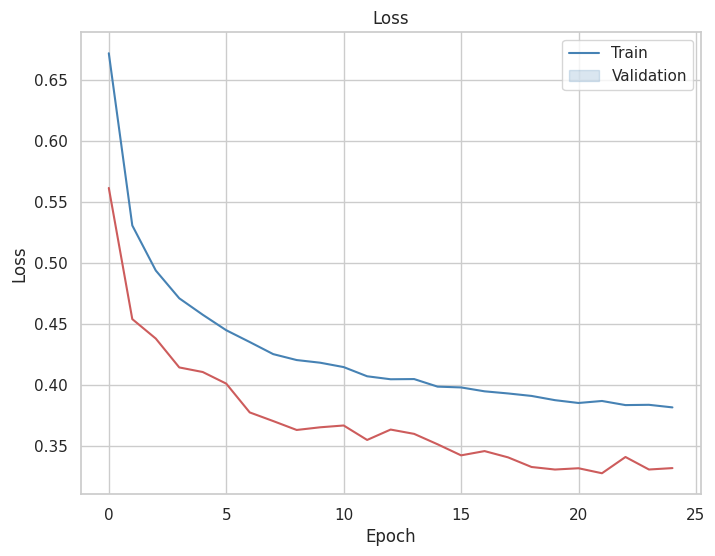

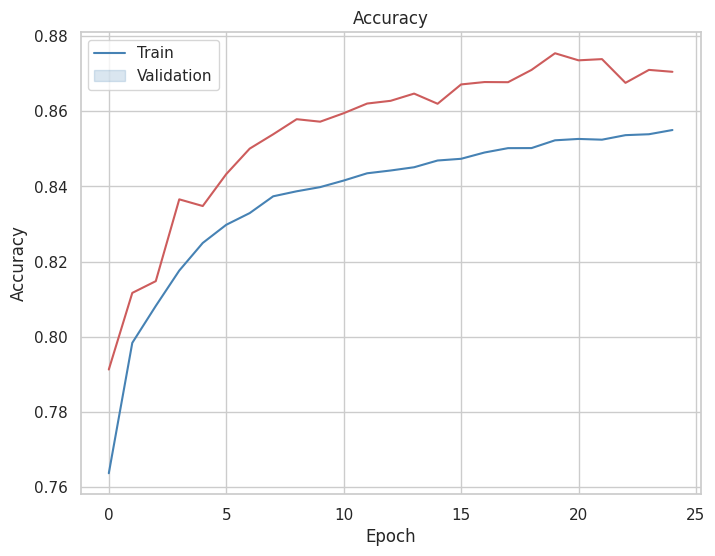

In [ ]:
#Plot the loss and accuracy for the model
plot_accuracy_loss(history_cnn)

In [84]:
# Function for changing the categorical prediction to numerical prediction
def y_pred_flattening(y_pred):
  y_pred_val=[]
  for i in y_pred:
    for j in i:
      val = np.argmax(j)
      y_pred_val.append(val)
  
  return y_pred_val

In [ ]:
from sklearn.metrics import classification_report

y_val_pred = cnn_model.predict(x_val)
y_val_pred_flat = y_pred_flattening(y_val_pred)
y_val_flat = y_pred_flattening(y_val)
print(classification_report(y_val_pred_flat, y_val_flat))

205/205 [==============================] - 1s 7ms/step
              precision    recall  f1-score   support

           0       0.97      0.87      0.92    215600
           1       0.90      0.88      0.89     12109
           2       0.93      0.89      0.91     15266
           3       0.38      0.83      0.52     18825

    accuracy                           0.87    261800
   macro avg       0.79      0.87      0.81    261800
weighted avg       0.92      0.87      0.89    261800



In [38]:
def plot_confusion_matrix(normalize):
  classes = ['standing/ walking','downstairs', 'upstairs', 'grass']
  tick_marks = [0.5,1.5,2.5,3.5]
  cn = confusion_matrix(y_val_flat, y_val_pred_flat,normalize = normalize)
  sns.heatmap(cn,cmap='plasma',annot=True)
  plt.rcParams["figure.figsize"] = (12,12)
  plt.xticks(tick_marks, classes)
  plt.yticks(tick_marks, classes)
  plt.title('Confusion Matrix')
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.show()

Confusion Matrix with Normalized Values for 1-D CNN Model


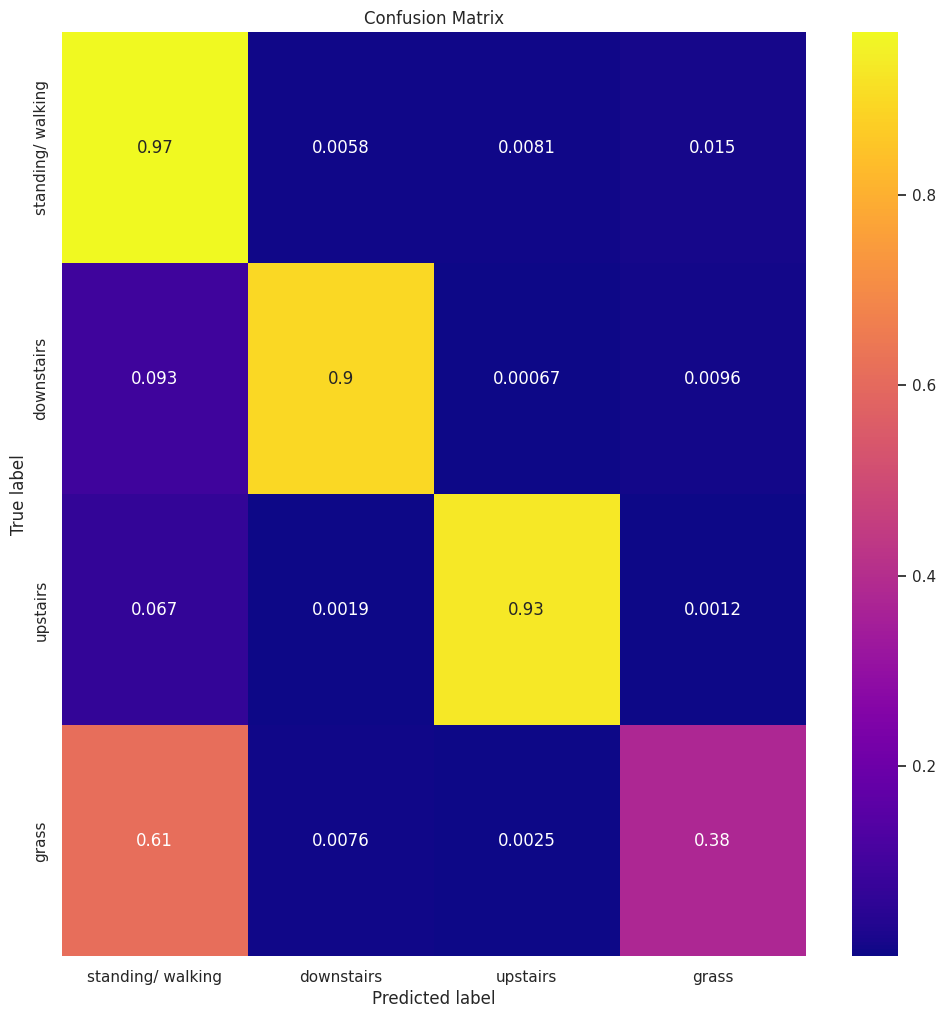

In [ ]:
print('Confusion Matrix with Normalized Values for 1-D CNN Model')
plot_confusion_matrix(normalize='true')

# LSTM <br> 
Used this for testing LSTM model  

In [ ]:
def create_LSTM():
  model = Sequential() 
  model.add(LSTM(128,  activation='relu', return_sequences=True,  input_shape=(40, 6)))
  model.add(BatchNormalization())
  model.add(Dropout(0.2))
  model.add(BatchNormalization())
  model.add(Dense(4, activation="softmax"))
  model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics = ['accuracy'])
  return model

In [ ]:
lstm_model =create_LSTM()

print(lstm_model.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 40, 128)           69120     
                                                                 
 batch_normalization_2 (Batc  (None, 40, 128)          512       
 hNormalization)                                                 
                                                                 
 dropout_5 (Dropout)         (None, 40, 128)           0         
                                                                 
 batch_normalization_3 (Batc  (None, 40, 128)          512       
 hNormalization)                                                 
                                                                 
 dense_1 (Dense)             (None, 40, 4)             516       
                                                                 
Total params: 70,660
Trainable params: 70,148
Non-trai

In [ ]:
lstm_model =create_LSTM()

print(lstm_model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 40, 100)           42800     
                                                                 
 dropout_4 (Dropout)         (None, 40, 100)           0         
                                                                 
 dense (Dense)               (None, 40, 4)             404       
                                                                 
Total params: 43,204
Trainable params: 43,204
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
history_lstm = lstm_model.fit(x_train, y_train, epochs=10, verbose=1, validation_data=(x_val, y_val))

Epoch 1/10
819/819 [==============================] - 78s 91ms/step - loss: 0.5713 - accuracy: 0.7979 - val_loss: 0.4309 - val_accuracy: 0.8358
Epoch 2/10
819/819 [==============================] - 82s 100ms/step - loss: 0.3979 - accuracy: 0.8552 - val_loss: 0.3715 - val_accuracy: 0.8654
Epoch 3/10
819/819 [==============================] - 75s 91ms/step - loss: 0.3652 - accuracy: 0.8680 - val_loss: 0.3552 - val_accuracy: 0.8680
Epoch 4/10
819/819 [==============================] - 81s 99ms/step - loss: 0.3456 - accuracy: 0.8749 - val_loss: 0.3697 - val_accuracy: 0.8633
Epoch 5/10
819/819 [==============================] - 75s 91ms/step - loss: 0.3306 - accuracy: 0.8806 - val_loss: 0.3348 - val_accuracy: 0.8785
Epoch 6/10
819/819 [==============================] - 82s 100ms/step - loss: 0.3167 - accuracy: 0.8861 - val_loss: 0.3234 - val_accuracy: 0.8800
Epoch 7/10
819/819 [==============================] - 77s 94ms/step - loss: 0.3066 - accuracy: 0.8892 - val_loss: 0.3108 - val_accurac

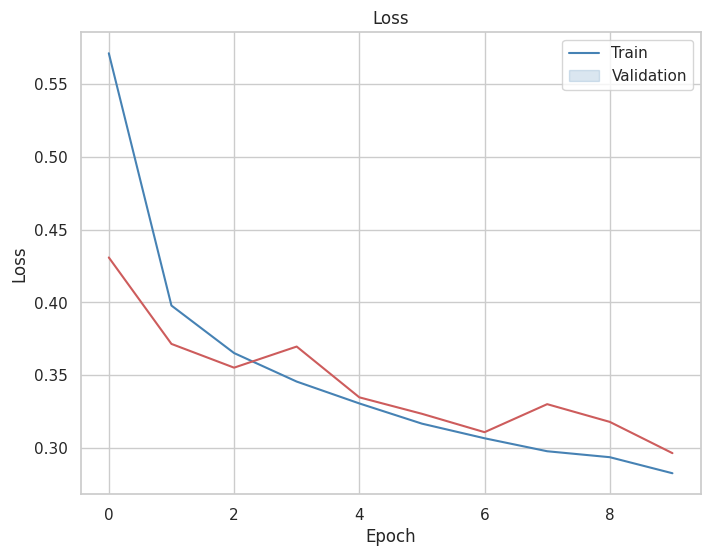

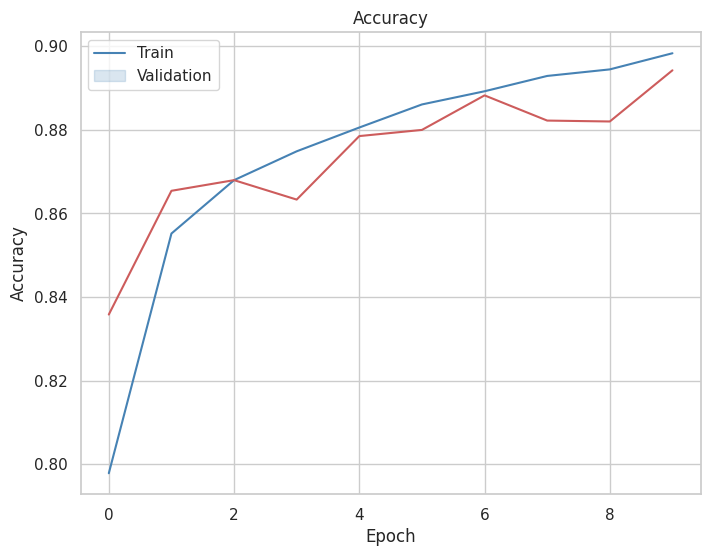

In [ ]:
#Plot the loss and accuracy for the model
plot_accuracy_loss(history_lstm)

In [ ]:
from sklearn.metrics import classification_report

y_val_pred = lstm_model.predict(x_val)
y_val_pred_flat = y_pred_flattening(y_val_pred)
y_val_flat = y_pred_flattening(y_val)
print(classification_report(y_val_pred_flat, y_val_flat))

205/205 [==============================] - 5s 22ms/step
              precision    recall  f1-score   support

           0       0.97      0.90      0.93    209802
           1       0.83      0.88      0.85     11118
           2       0.85      0.93      0.89     13250
           3       0.57      0.86      0.69     27630

    accuracy                           0.89    261800
   macro avg       0.80      0.89      0.84    261800
weighted avg       0.92      0.89      0.90    261800



#BidirectionalLSTM + LSTM <br>
LearningRate-0.001 <br>
Dropout and BatchNormalization<br> 
Used this for C2 submission

In [29]:
def create_biLSTM(lr = 0.001):
  model = Sequential()
  model.add(Bidirectional(LSTM(128,return_sequences=True,activation="relu", input_shape=(40,6))))
  model.add(Dropout(0.2))
  model.add(BatchNormalization())
  model.add(LSTM(64, return_sequences=True, activation="relu"))
  model.add(Dropout(0.2))
  model.add(Dense(32, activation="relu"))
  model.add(Dense(4, activation="softmax"))
  model.compile(optimizer=Adam(learning_rate=lr),  loss='categorical_crossentropy', metrics = ['accuracy'])
  return model

In [33]:
bilstm_model =create_biLSTM(0.001)

history_bilstm = bilstm_model.fit(x_train, y_train, epochs=20, batch_size = 32, verbose=1, validation_data=(x_val, y_val))

Epoch 1/20
819/819 [==============================] - 200s 236ms/step - loss: 0.4051 - accuracy: 0.8542 - val_loss: 0.2666 - val_accuracy: 0.9095
Epoch 2/20
819/819 [==============================] - 194s 237ms/step - loss: 0.2635 - accuracy: 0.9085 - val_loss: 0.2534 - val_accuracy: 0.9139
Epoch 3/20
819/819 [==============================] - 185s 225ms/step - loss: 0.2249 - accuracy: 0.9229 - val_loss: 0.2152 - val_accuracy: 0.9273
Epoch 4/20
819/819 [==============================] - 184s 225ms/step - loss: 0.1967 - accuracy: 0.9336 - val_loss: 0.2056 - val_accuracy: 0.9286
Epoch 5/20
819/819 [==============================] - 194s 236ms/step - loss: 0.1829 - accuracy: 0.9382 - val_loss: 0.2193 - val_accuracy: 0.9220
Epoch 6/20
819/819 [==============================] - 184s 224ms/step - loss: 0.1696 - accuracy: 0.9426 - val_loss: 0.1875 - val_accuracy: 0.9364
Epoch 7/20
819/819 [==============================] - 191s 233ms/step - loss: 0.1627 - accuracy: 0.9457 - val_loss: 0.1792 -

In [34]:
print(bilstm_model.summary())

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_7 (Bidirectio  (None, 40, 256)          138240    
 nal)                                                            
                                                                 
 dropout_14 (Dropout)        (None, 40, 256)           0         
                                                                 
 batch_normalization_12 (Bat  (None, 40, 256)          1024      
 chNormalization)                                                
                                                                 
 lstm_15 (LSTM)              (None, 40, 64)            82176     
                                                                 
 dropout_15 (Dropout)        (None, 40, 64)            0         
                                                                 
 dense_14 (Dense)            (None, 40, 32)           

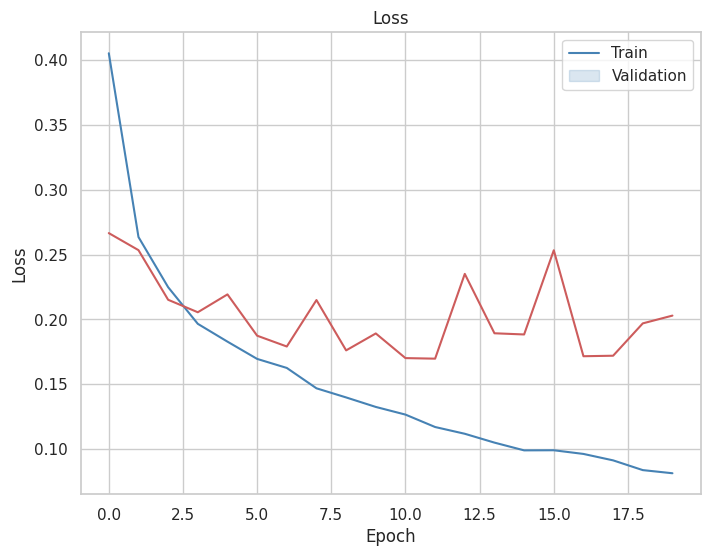

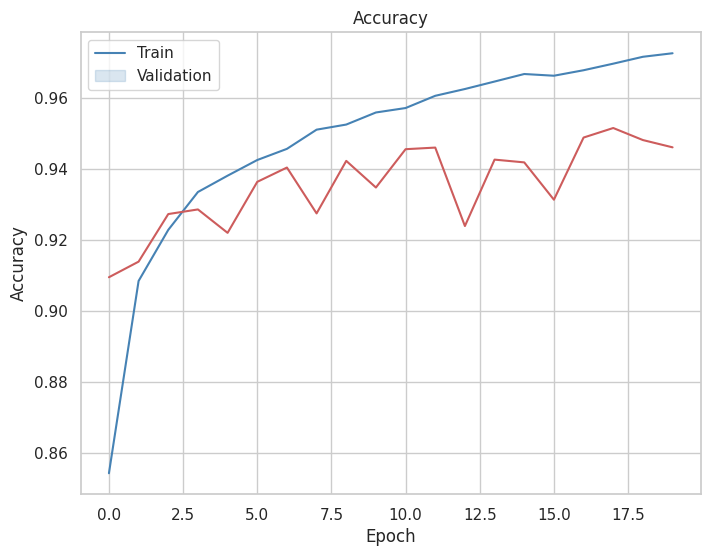

In [35]:
#Plot the loss and accuracy for the model
plot_accuracy_loss(history_bilstm)

In [85]:
from sklearn.metrics import classification_report

y_val_pred = bilstm_model.predict(x_val)
y_val_pred_flat = y_pred_flattening(y_val_pred)
y_val_flat = y_pred_flattening(y_val)
print(classification_report(y_val_pred_flat, y_val_flat))

205/205 [==============================] - 15s 72ms/step
              precision    recall  f1-score   support

           0       0.97      0.96      0.96    196355
           1       0.94      0.93      0.94     12070
           2       0.95      0.94      0.95     14646
           3       0.83      0.89      0.86     38729

    accuracy                           0.95    261800
   macro avg       0.92      0.93      0.93    261800
weighted avg       0.95      0.95      0.95    261800



Confusion Matrix with Normalized Values for BiLSTM Model


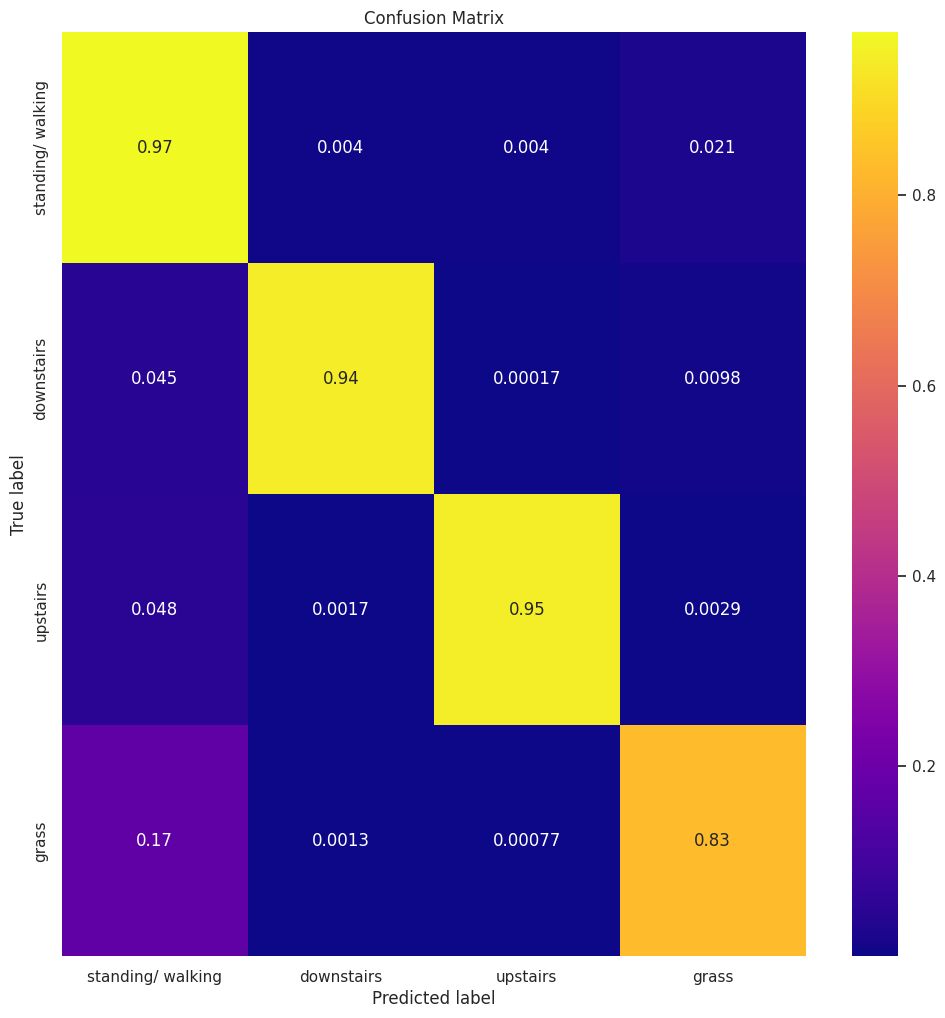

In [86]:
print('Confusion Matrix with Normalized Values for BiLSTM Model')
plot_confusion_matrix(normalize='true')

#BidirectionalLSTM +LSTM <br>

Removed BatchNormalization, which improved accuracy<br>
Used this for submission C3

In [40]:
def create_biLSTM1():
  model = Sequential()
  model.add(Bidirectional(LSTM(128,return_sequences=True, input_shape=(40,6))))
  model.add(Dropout(0.2))
  model.add(LSTM(64, return_sequences=True, activation="relu"))
  model.add(Dropout(0.2))
  model.add(Dense(32, activation="relu"))
  model.add(Dense(4, activation="softmax"))
  model.compile(optimizer=Adam(learning_rate=0.001),  loss='categorical_crossentropy', metrics = ['accuracy'])
  return model

In [41]:
biLSTM1_model =create_biLSTM1()
history_biLSTM1 = biLSTM1_model.fit(x_train, y_train, epochs=25, verbose=1, validation_data=(x_val, y_val))

Epoch 1/25
819/819 [==============================] - 262s 303ms/step - loss: 0.4618 - accuracy: 0.8327 - val_loss: 0.3129 - val_accuracy: 0.8903
Epoch 2/25
819/819 [==============================] - 214s 261ms/step - loss: 0.2947 - accuracy: 0.8982 - val_loss: 0.2943 - val_accuracy: 0.8974
Epoch 3/25
819/819 [==============================] - 203s 248ms/step - loss: 0.2534 - accuracy: 0.9128 - val_loss: 0.2278 - val_accuracy: 0.9226
Epoch 4/25
819/819 [==============================] - 204s 250ms/step - loss: 0.2225 - accuracy: 0.9233 - val_loss: 0.2345 - val_accuracy: 0.9178
Epoch 5/25
819/819 [==============================] - 199s 243ms/step - loss: 0.2022 - accuracy: 0.9318 - val_loss: 0.2042 - val_accuracy: 0.9316
Epoch 6/25
819/819 [==============================] - 191s 233ms/step - loss: 0.1863 - accuracy: 0.9373 - val_loss: 0.1995 - val_accuracy: 0.9328
Epoch 7/25
819/819 [==============================] - 194s 237ms/step - loss: 0.1740 - accuracy: 0.9405 - val_loss: 0.1815 -

In [42]:
biLSTM1_model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_8 (Bidirectio  (None, 40, 256)          138240    
 nal)                                                            
                                                                 
 dropout_16 (Dropout)        (None, 40, 256)           0         
                                                                 
 lstm_17 (LSTM)              (None, 40, 64)            82176     
                                                                 
 dropout_17 (Dropout)        (None, 40, 64)            0         
                                                                 
 dense_16 (Dense)            (None, 40, 32)            2080      
                                                                 
 dense_17 (Dense)            (None, 40, 4)             132       
                                                      

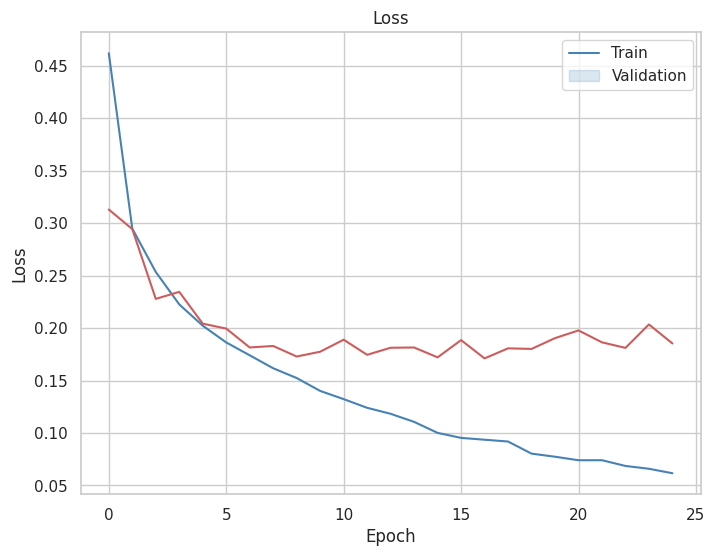

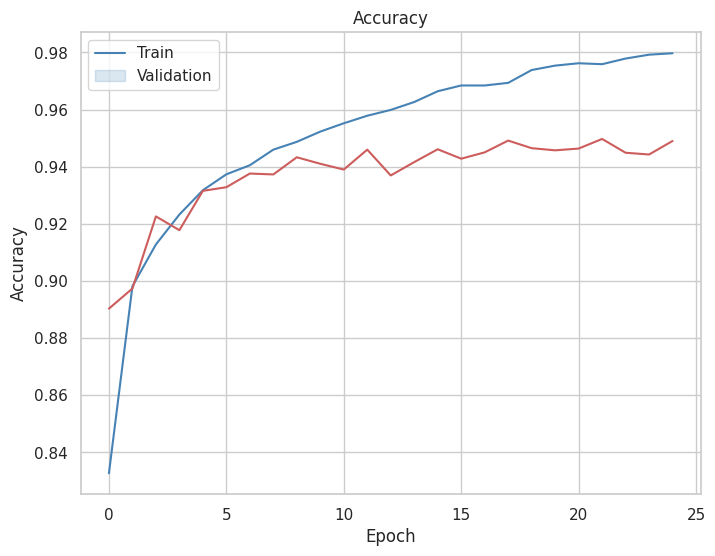

In [47]:
#Plot the loss and accuracy for the model
plot_accuracy_loss(history_biLSTM1)

In [45]:
from sklearn.metrics import classification_report

y_val_pred_flat = y_pred_flattening(biLSTM1_model.predict(x_val))
y_val_flat = y_pred_flattening(y_val)
print(classification_report(y_val_pred_flat, y_val_flat))

205/205 [==============================] - 19s 82ms/step
              precision    recall  f1-score   support

           0       0.97      0.97      0.97    193616
           1       0.93      0.94      0.94     11697
           2       0.95      0.93      0.94     14797
           3       0.88      0.87      0.88     41690

    accuracy                           0.95    261800
   macro avg       0.93      0.93      0.93    261800
weighted avg       0.95      0.95      0.95    261800



Confusion Matrix with Normalized Values for improved BiLSTM Model


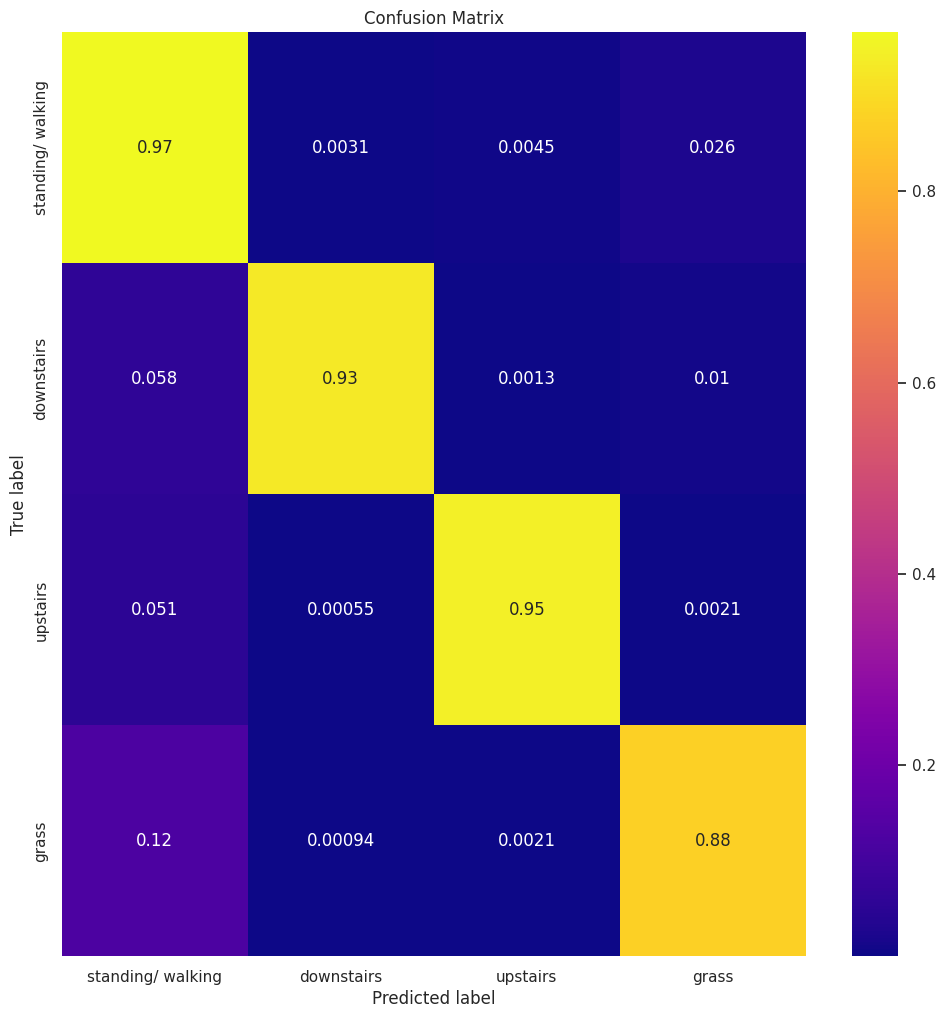

In [62]:
print('Confusion Matrix with Normalized Values for improved BiLSTM Model')
plot_confusion_matrix(normalize='true')

# Prediction

## Read the test data files

In [55]:
files_path = "/content/drive/MyDrive/ECE542_sp2022_Project_TerrainRecognition/"

# test_files = [f for f in os.listdir(test_files_path) if f.startswith(f"subject")]
# test_pairs = find_pairs(test_files)
# print(test_files)
# Read all test data files 
x_test9 = pd.read_csv(f'{files_path}/TestData/subject_009_01__x.csv',names = [ 'accX','accY','accZ','gyroX','gyroY','gyroZ'])
x_test10 = pd.read_csv(f'{files_path}/TestData/subject_010_01__x.csv',names = [ 'accX','accY','accZ','gyroX','gyroY','gyroZ'])
x_test11 = pd.read_csv(f'{files_path}/TestData/subject_011_01__x.csv',names = [ 'accX','accY','accZ','gyroX','gyroY','gyroZ'])
x_test12 = pd.read_csv(f'{files_path}/TestData/subject_012_01__x.csv',names = [ 'accX','accY','accZ','gyroX','gyroY','gyroZ'])

print(x_test10)
#x_test_009 = x_test_009.drop('time', axis=1)
#x_test_010 = x_test_010.drop('time', axis=1)
#x_test_011 = x_test_011.drop('time', axis=1)
#x_test_012 = x_test_012.drop('time', axis=1)

           accX      accY      accZ     gyroX     gyroY     gyroZ
0      1.677089  9.653418  0.216836 -0.003305 -0.001139 -0.010541
1      1.599285  9.645357  0.219285  0.002334 -0.001723 -0.015168
2      1.535950  9.650814  0.244864 -0.005993 -0.006330 -0.014107
3      1.529706  9.646471  0.263529 -0.000504  0.005051 -0.007983
4      1.643437  9.630000  0.226718 -0.000565 -0.003373 -0.006667
...         ...       ...       ...       ...       ...       ...
49076  1.097956  9.700940  0.743038  0.020419 -0.005064 -0.051111
49077  1.067204  9.659606  0.736398  0.025361 -0.028425 -0.054380
49078  0.916539  9.551814  0.712363  0.009759 -0.038648 -0.053382
49079  0.811369  9.570456  0.790000  0.004008 -0.030436 -0.051745
49080  0.843983  9.608862  0.770569 -0.000373 -0.011842 -0.046294

[49081 rows x 6 columns]


In [57]:
x_test9_scaled = scaler.transform(x_test9)
x_test_9 = pd.DataFrame(x_test9_scaled, columns = [ 'accX','accY','accZ','gyroX','gyroY','gyroZ'])

x_test_10_scaled = scaler.transform(x_test10)
x_test_10 = pd.DataFrame(x_test_10_scaled, columns = [ 'accX','accY','accZ','gyroX','gyroY','gyroZ'])

x_test_11_scaled = scaler.transform(x_test11)
x_test_11 = pd.DataFrame(x_test_11_scaled, columns = [ 'accX','accY','accZ','gyroX','gyroY','gyroZ'])

x_test_12_scaled = scaler.transform(x_test12)
x_test_12 = pd.DataFrame(x_test_12_scaled, columns = [ 'accX','accY','accZ','gyroX','gyroY','gyroZ'])

print(x_test_9)

           accX      accY      accZ     gyroX     gyroY     gyroZ
0     -0.040554  0.098617 -1.891367 -0.001098 -0.021091  0.093177
1     -0.037597  0.098164 -1.887809 -0.001443 -0.017222  0.097109
2     -0.035832  0.098300 -1.896053 -0.000810 -0.014698  0.097908
3     -0.032506  0.099796 -1.896198 -0.001318 -0.012437  0.098696
4     -0.025136  0.100840 -1.899250 -0.001449 -0.011147  0.097908
...         ...       ...       ...       ...       ...       ...
37986  0.052472  0.142362 -1.762371 -0.001380 -0.014957  0.092660
37987  0.056921  0.138559 -1.763627 -0.001927 -0.014379  0.089246
37988  0.052496  0.140926 -1.761188 -0.000833 -0.013609  0.089919
37989  0.058581  0.143141 -1.766537 -0.000959 -0.015480  0.090835
37990  0.062086  0.142041 -1.763472 -0.001609 -0.016584  0.087803

[37991 rows x 6 columns]


## Standardize the Test Data set

Standardize the test data set 

In [58]:
# Defining Function to Create window for test dataset
def sliding_window_test(df_x, windowsize=40):
  window_x=[]
  for i in range(0, len(df_x)-windowsize, windowsize):
    window_x.append([df_x.values[i:i+windowsize]])
  window_x=np.array(window_x).reshape(-1,windowsize,6)
  
  return window_x


In [59]:
#Creating frames for all test subjects
x_09 = sliding_window_test(x_test_9, 40)
x_10 = sliding_window_test(x_test_10, 40)
x_11 = sliding_window_test(x_test_11, 40)
x_12 = sliding_window_test(x_test_12, 40)

In [60]:
print(x_09.shape,x_10.shape,x_11.shape,x_12.shape)

(949, 40, 6) (1227, 40, 6) (1294, 40, 6) (1132, 40, 6)


## Perform prediction and transform the predicted categorical values to integer labels

In [66]:
y_pred_9 = biLSTM1_model.predict(x_09)
y_pred_10 = biLSTM1_model.predict(x_10)
y_pred_11 = biLSTM1_model.predict(x_11)
y_pred_12 = biLSTM1_model.predict(x_12)

36/36 [==============================] - 6s 151ms/step


In [64]:
# Function for changing the categorical prediction to numerical prediction
def y_pred_flat(y_pred):
  y_pred_data=[]
  for i in y_pred:
    for j in i:
      y_pred_data.append(np.argmax(j))
  
  return y_pred_data
  


In [68]:
yhat_9_data=pd.DataFrame(y_pred_flat(y_pred_9.tolist()), columns=['Output'])
yhat_10_data=pd.DataFrame(y_pred_flat(y_pred_10.tolist()), columns=['Output'])
yhat_11_data=pd.DataFrame(y_pred_flat(y_pred_11.tolist()), columns=['Output'])
yhat_12_data=pd.DataFrame(y_pred_flat(y_pred_12.tolist()), columns=['Output'])

In [77]:
subjects = {'09':yhat_9_data ,'10':yhat_10_data ,'11':yhat_11_data ,'12':yhat_12_data } 

In [80]:
def read_test_data(y_hat_data , subject = '09'):

  x_subject = pd.read_csv(f"{files_path}TestData/subject_0{subject}_01__x.csv", names=[ 'accX','accY','accZ','gyroX','gyroY','gyroZ'])
  x_subject_time = pd.read_csv(f"{files_path}TestData/subject_0{subject}_01__x_time.csv", names = ["time"])
  x_subject['time'] = x_subject_time['time']
  x_subject = x_subject.join(y_hat_data, how='left')
  x_subject['Output'] = x_subject['Output'].fillna(0)
  x_subject['time'] = x_subject['time'].apply(lambda x:int(x*100)/100)

  y_subject_time = pd.read_csv(f"{files_path}TestData/subject_0{subject}_01__y_time.csv", names = ["time"])
  return pd.merge(x_subject, y_subject_time, on='time', how='inner')

In [81]:
x_test_data = []
for subject in subjects:
  print(subject)
  x_test_data.append(read_test_data(subjects[subject], subject))


09
10
11
12


In [82]:
print(x_test_data[2])

           accX      accY      accZ     gyroX     gyroY     gyroZ     time  \
0      0.460726  8.446290  4.920000 -0.002239 -0.005522 -0.006625     0.02   
1      0.579961  8.459977  4.889984  0.003333  0.009301  0.014619     0.12   
2      0.589684  8.420000  4.840000  0.004077 -0.003149 -0.007969     0.22   
3      0.490409  8.440614  4.900614  0.002019  0.004444 -0.001815     0.32   
4      0.540253  8.430000  4.919240  0.002420  0.003531  0.004444     0.42   
...         ...       ...       ...       ...       ...       ...      ...   
12935 -0.301764  9.769607  0.163921 -0.004830 -0.004151 -0.005170  1293.52   
12936 -0.220000  9.743044  0.210000 -0.002950 -0.008133  0.001111  1293.62   
12937 -0.283381  9.767794  0.190000 -0.000770 -0.004357 -0.002222  1293.72   
12938 -0.257036  9.787223  0.182777 -0.002965 -0.001854  0.002222  1293.82   
12939 -0.314415  9.777923  0.194415 -0.002222  0.001512  0.003333  1293.92   

       Output  
0         0.0  
1         0.0  
2         0.0  

In [83]:
save_path = '/content/drive/MyDrive/ProjectC3/'

x_test_data[0]['Output'].to_csv(f'{save_path}subject_009_01__y_final_78.csv', index=False, header=False)
x_test_data[1]['Output'].to_csv(f'{save_path}subject_010_01__y_final_78.csv', index=False, header=False)
x_test_data[2]['Output'].to_csv(f'{save_path}subject_011_01__y_final_78.csv', index=False, header=False)
x_test_data[3]['Output'].to_csv(f'{save_path}subject_012_01__y_final_78.csv', index=False, header=False)